# Introduction
The purpose of this notebook is to create Custom Transformers to include this steps into a Pipeline.

## Set environment

In [1]:
# 
import pandas as pd
import numpy as np
import pingouin as pg
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats

# 
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\sebas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Import data

In [2]:
listings = pd.read_csv('listings_detailed.csv')

In [3]:
keep_cols = ['minimum_nights', 'maximum_nights', 'host_is_superhost']
host_cols = [col for col in listings.columns if 'host' in col if col not in keep_cols]
night_cols = [col for col in listings.columns if 'nights' in col if col not in keep_cols]
other_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 
              'picture_url', 'availability_30', 'availability_60', 'availability_90', 
              'first_review', 'last_review', 'license', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'calendar_last_scraped', 'neighborhood_overview',
              'neighbourhood', 'has_availability', 'amenities', 'host_id', 'id', 'property_type']

# empty columns
mask_empty_cols = listings.isnull().sum() == len(listings)
empty_cols = listings.columns[mask_empty_cols].to_list()

# columns to drop
cols_drop = host_cols + other_cols + night_cols + empty_cols

# drop columns
listings.drop(columns=cols_drop, inplace=True)

We are going to remove 'bathroom_text', as we plan to create a new feature that encodes the number of bathrooms and if it is shared or not. We cannot include this in the Custom Transformer as it will raise an error when trying to predict based on train_X, as it will be looking for the column 'bathroom_text'in the Custom Transformer, but it would be already dropped. So as we are only going to transform the data (we do not need the Custom Transformer to learn from the data) we will do this as a pre-processing step before splitting into train and test sets.

In [4]:
def preprocess(df):

    # masks bathroom type
    shared_bathroom = (df['bathrooms_text'].str.contains('shared')) | (df['bathrooms_text'].str.contains('Shared'))
    half_bathroom = df['bathrooms_text'].str.contains('half-bath')
    
    # initiate 'bathroom type' with default value
    df['bathroom_type'] = 'no shared'
    # change values based on condition
    df.loc[shared_bathroom, 'bathroom_type'] = 'shared'

    # number of bathrooms (numeric)
    df['bathrooms'] = df['bathrooms_text'].str.extract('(\d+(?:\.\d+)?)', expand=False)
    df.loc[half_bathroom, 'bathrooms'] = 0.5
    df['bathrooms'] = df['bathrooms'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    # drop uneccesary column
    df.drop(columns='bathrooms_text', inplace=True)
    
    return df

In [5]:
listings = preprocess(listings)

Split into predictors (X) and target variable (y)

In [6]:
X = listings.drop(columns='price')
y = listings['price'].str.replace(',', '').str.slice(start=1).apply(lambda x: pd.to_numeric(x, errors='coerce'))

Split into train (70%) and test sets (30%)

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.3, random_state=42)

print('X train and test sets shapes: ' + str(train_X.shape), str(test_X.shape), 
      '\ny train and test sets shapes: ' + str(train_y.shape), str(test_y.shape))

# reset index for further preprocessing
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

X train and test sets shapes: (3702, 23) (1587, 23) 
y train and test sets shapes: (3702,) (1587,)


As Sklearn does not allow to modify target variables, we will perform outlier removal as a preprocessing step before fitting the Pipeline. We will see how the model performs with outliers present or absent in the data. We will also implement standardization to minimize the impact of outliers in the model. In any case, outliers will be only removed computing the IQR based on the train set, using the lower and upper limit computed from the train set to remove outleirs from the test set.

In [8]:
def iqr_outlier_removal(train_X, test_X, train_y, test_y):
    """
    Compute Tukey's Interquantile Range (IQR) based on the
    train set. Stores Q1 and Q3, as well as IQR from the
    train sets and applies them to remove outliers from the
    test set.
    
    Input:
        dv: numeric variable as a pandas Series.
    Output:
        outlier: value of the outlier in the dv.
        outlier_loc: index of the outlier.
    """
    
    Q1, Q3 = np.percentile(train_y, [25, 75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR 
    upper_limit = Q3 + 1.5 * IQR 
    
    # store outliers and its location in the df
    outlier_train = []
    outlier_loc_train = []
    for i, x in enumerate(train_y): 
        if ((x > upper_limit) or (x < lower_limit)): 
            outlier_train.append(x)
            outlier_loc_train.append(i)
    
    # store outliers and its location in the df
    outlier_test = []
    outlier_loc_test = []
    for i, x in enumerate(test_y): 
        if ((x > upper_limit) or (x < lower_limit)): 
            outlier_test.append(x)
            outlier_loc_test.append(i)
            
    print('IQR is: ' + str(IQR) + ' with a lower limit: ' + str(lower_limit) + ' and a upper limit: ' + str(upper_limit) + '\n' +
          'In general we have: ' + str(len(outlier_train)) + ' outliers in the train dataset')
    print('In general we have: ' + str(len(outlier_test)) + ' outliers in the test dataset')
    
    # remove outliers
    train_X.drop(index=outlier_loc_train, inplace=True)
    train_X.reset_index(drop=True, inplace=True)
    train_y.drop(index=outlier_loc_train, inplace=True)
    train_y.reset_index(drop=True, inplace=True)
    
    test_X.drop(index=outlier_loc_test, inplace=True)
    test_X.reset_index(drop=True, inplace=True)
    test_y.drop(index=outlier_loc_test, inplace=True)
    test_y.reset_index(drop=True, inplace=True)
    
    return train_X, test_X, train_y, test_y

IQR is: 44.0 with a lower limit: -25.0 and a upper limit: 151.0
In general we have: 242 outliers in the train dataset
In general we have: 100 outliers in the test dataset


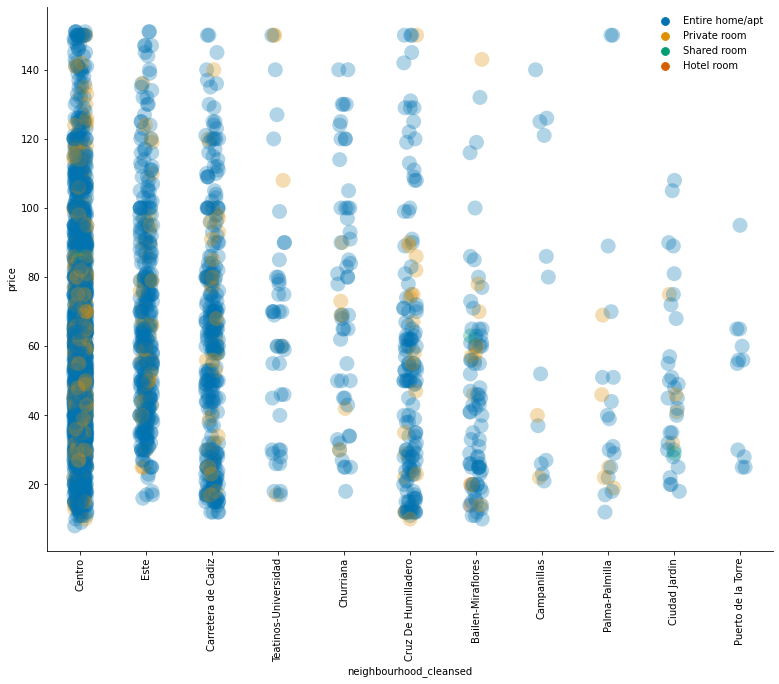

In [9]:
train_X, test_X, train_y, test_y = iqr_outlier_removal(train_X, test_X, train_y, test_y)

# plot
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=train_X['neighbourhood_cleansed'], y=train_y, palette='colorblind', hue=X['room_type'], size=15, alpha=.3)
plt.legend(frameon=False)
plt.xticks(rotation=90)
sns.despine()

We have seen that the model performs better when the target variable is normally distributed, although if we avoid transforming the target variable, that will make the interpretation easier, as we avoid reversing the transformation.

We are going to transform the target variable before introduce it into the Pipeline, in order to perform necessary steps before fitting the model.

We will also see how the model performs when we use the untransformed target variable in the previous steps to model fitting and only applying the transformation just before fitting the model using Sklearn TransformedTargetRegressor. In this case we will use Kruskal-Wallis for feature selection as the variable will not be normally distributed to apply ANOVA.

* The benefits of transforming the target variable can be checked in the following documentation: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

In [10]:
train_y_tr = np.sqrt(train_y)
test_y_tr = np.sqrt(test_y)

In [11]:
def plot_dist(df, dv_list=None, transformation=None):
    """
    Plot distribution of data. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        dv_list: list of variables to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable.
    """
    
    
    if dv_list == None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df.dropna(), plot=ax[1])
        plt.show()
        
    elif dv_list != None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
            
        for dv in dv_list:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()

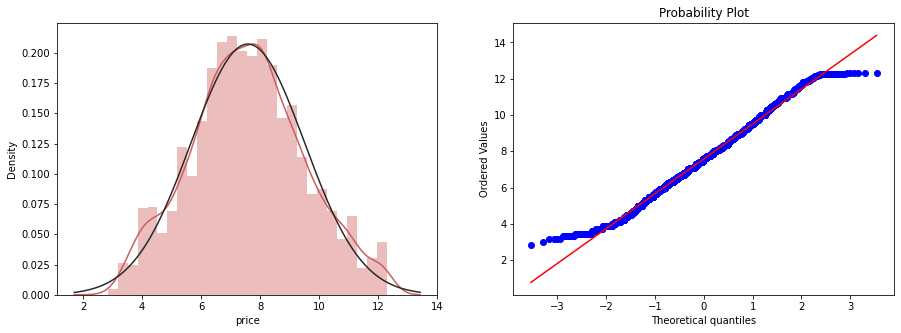

In [12]:
plot_dist(train_y_tr)

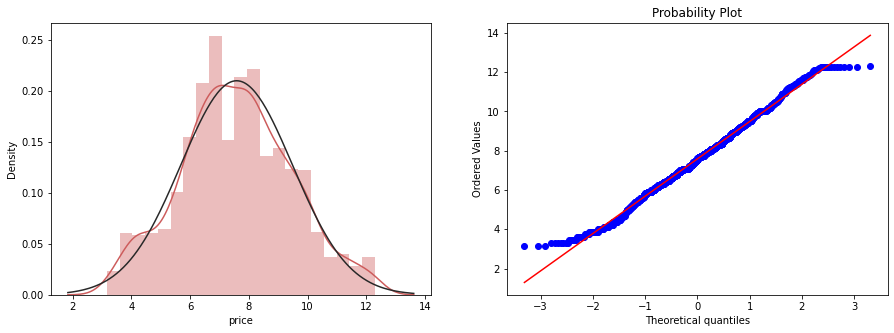

In [13]:
plot_dist(test_y_tr)

We see a high number of missing values in the review data. We are going to compute correlations to see possible patterns in the review scores based on other features in order to impute them. Although, no systematic correlations were found for the review scores, so we are going to impute the missing values just with the mean of the whole column.

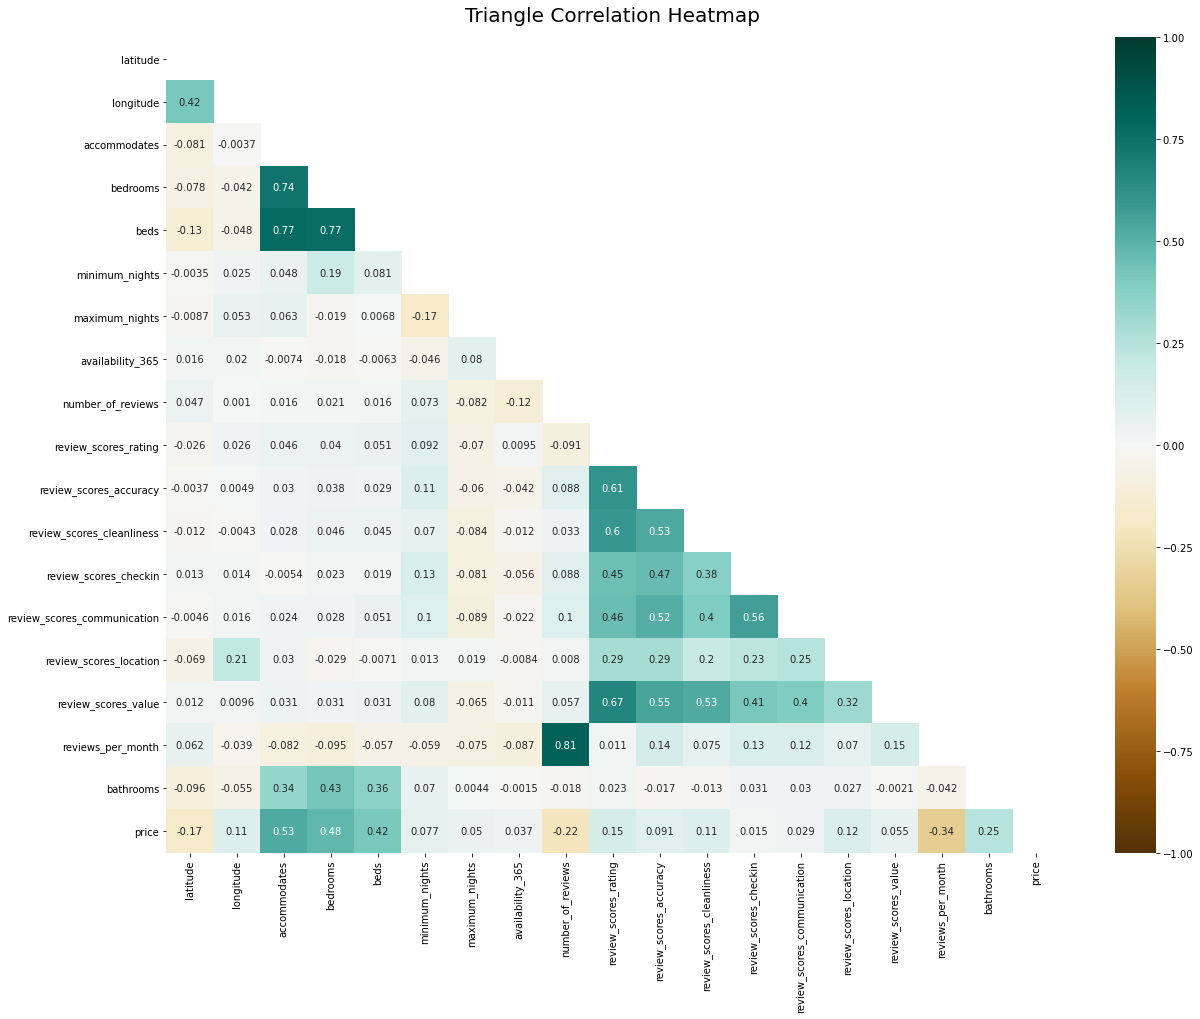

In [14]:
# concatenate the coded categorical variables with the predicted variable
train_coded = pd.concat([train_X, train_y_tr], axis=1)

# compute correlations
np.triu(np.ones_like(train_coded.corr(method='spearman')))
plt.figure(figsize=(20, 15))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_coded.corr(method='spearman'), dtype=np.bool))
heatmap = sns.heatmap(train_coded.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

# Custom Transformers

In [15]:
class CustomTransformerFeatures(TransformerMixin):
    
    def __init__(self):
        super().__init__()
        print('Transforming data. In the CustomTransformerFeatures init method: ')

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # masks sizes
        size_1 = (X['accommodates'] <= 3)
        size_2 = (X['accommodates'] >= 4) & (X['accommodates'] <= 7)
        size_3 = (X['accommodates'] >= 8) & (X['accommodates'] <= 20)
        
        # initiate new columns
        X['size'] = ''
        
        # sizes
        X.loc[size_1, 'size'] = 'small'
        X.loc[size_2, 'size'] = 'medium'
        X.loc[size_3, 'size'] = 'large'
        
        return X

In [16]:
class CustomImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.acc_bedr = {}
        self.acc_beds = {}
        self.acc_bathr = {}
        # SimpleImputer uses np.nan and 'mean' by default
        self.imp_mean = SimpleImputer()
        self.columns_order = None
        print('Transforming data. In the CustomImputer init method: ')

    def fit(self, X, y=None):
        self.acc_bedr = X.groupby(['accommodates'])['bedrooms'].mean()
        self.acc_beds = X.groupby(['accommodates'])['beds'].mean()
        self.acc_bathr = X.groupby(['accommodates'])['bathrooms'].mean()
        self.imp_mean.fit(X.select_dtypes(include=[float, int]))
        self.columns_order = X.columns
        
        return self

    def transform(self, X, y=None):
        # apply values based on dictionaries 
        for (key_bedr, value_bedr), (key_beds, value_beds), (key_bathr, value_bathr) in zip(self.acc_bedr.items(), 
                                                                                            self.acc_beds.items(), 
                                                                                            self.acc_bathr.items()):
            
            X.loc[((X['bedrooms'].isnull()) & (X['accommodates'] == key_bedr)), 'bedrooms'] = value_bedr
            X.loc[((X['beds'].isnull()) & (X['accommodates'] == key_beds)), 'beds'] = value_beds
            X.loc[((X['bathrooms'].isnull()) & (X['accommodates'] == key_bathr)), 'bathrooms'] = value_bathr
        
        # impute missing values only in numeric columns
        X_imp_mean = pd.DataFrame(data=self.imp_mean.transform(X.select_dtypes(include=[float, int])), 
                                  index=X.index, 
                                  columns=X.select_dtypes(include=[float, int]).columns)
        # concatenate both DataFrames
        X = pd.concat([X.select_dtypes(exclude=['float', 'int']), X_imp_mean], axis=1)
        
        # set columns original order
        X = X.reindex(columns=self.columns_order)
        
        return X

As we have transformed the target variable to be normally distributed, we will use ANOVA to select categorical features. In case we do not want to transform the target variable, we can use Kruskal-Wallis.

In [17]:
class FeatureSelectionANOVA(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.cat_features = None
        self.drop_features = []
        print('Transforming data. In the FeatureSelectionANOVA init method: ')

    def fit(self, X, y):
        self.cat_features = X.select_dtypes(include=object).columns.to_list()
        df = pd.concat([X, y], axis=1)
        
        for feature in self.cat_features:
            p_value = pg.anova(data=df, dv=y.name, between=feature, detailed=True, effsize='np2')['p-unc'].iloc[0]
            if p_value > .05:
                self.drop_features.append(feature)

        return self
    
    def transform(self, X, y=None):
        X.drop(columns=self.drop_features, inplace=True)
        
        return X

In [18]:
class FeatureSelectionKruskal(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.cat_features = None
        self.drop_features = []
        print('Transforming data. In the FeatureSelectionKruskal init method: ')

    def fit(self, X, y):
        self.cat_features = X.select_dtypes(include=object).columns.to_list()
        df = pd.concat([X, y], axis=1)
        
        for feature in self.cat_features:
            p_value = pg.kruskal(data=df, dv=y.name, between=feature, detailed=True)['p-unc'].iloc[0]
            if p_value > .05:
                self.drop_features.append(feature)

        return self
    
    def transform(self, X, y=None):
        X.drop(columns=self.drop_features, inplace=True)
        
        return X

In [19]:
class CustomOrdinal(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories, target_column):
        super().__init__()
        self.categories = categories
        self.target_column = target_column
        self.encoder = OrdinalEncoder(categories=[self.categories])
        print('Transforming data. In the CustomOrdinal init method: ')

    def fit(self, X, y=None):              
        self.encoder.fit(X[self.target_column].values.reshape(-1, 1))
        return self
    
    def transform(self, X, y=None):
        X[self.target_column] = self.encoder.transform(X[self.target_column].values.reshape(-1, 1))
        
        return X

In [20]:
class CustomDummy(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        print('Transforming data. In the CustomDummy init method: ')

    def fit(self, X, y=None):
        X_dummies = pd.get_dummies(X, drop_first=True)
        self.dummies = X_dummies.columns
                
        return self
    
    def transform(self, X, y=None):
        X_dummies = pd.get_dummies(X)
        X = X_dummies.reindex(columns=self.dummies, fill_value=0)
        
        return X

In [21]:
class MulticollinearityVIF(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.vif = pd.DataFrame()
        self.removed_features = []
        print('Transforming data. In the MulticollinearityVIF init method: ')

    def fit(self, X, y=None):
        self.vif['variables'] = X.columns
        self.vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        self.vif.sort_values(by='VIF', ascending=False, inplace=True)
        
        # deep copy of the original VIF values
        vif_original = self.vif.copy(deep=True)
        
        # iterate and removed VIF values greater or equal to 10
        while self.vif['VIF'].iloc[0] >= 10:
            X.drop(columns=self.vif['variables'].iloc[0], inplace=True)
            self.removed_features.append(self.vif['variables'].iloc[0])
            self.vif = pd.DataFrame()
            self.vif['variables'] = X.columns
            self.vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            self.vif.sort_values(by='VIF', ascending=False, inplace=True)
                
        return self
    
    def transform(self, X, y=None):
        X = X[X.columns[~X.columns.isin(self.removed_features)]]
        
        return X

In [22]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.not_dummy_cols = None
        self.scaler = StandardScaler()
        print('Transforming data. In the CustomStandardizer init method: ')

    def fit(self, X, y=None):
        # list of not dummy cols
        self.not_dummy_cols = X.select_dtypes(exclude='uint8').columns.to_list()
        self.scaler.fit(X[self.not_dummy_cols])
        
        return self
    
    def transform(self, X, y=None):
        # dummy cols df
        X_dummy = X.drop(columns=self.not_dummy_cols).reset_index(drop=True)
        # standardize not dummy cols
        X_scaled = self.scaler.transform(X[self.not_dummy_cols])
        X_scaled = pd.DataFrame(data=X_scaled, columns=X[self.not_dummy_cols].columns)
        
        X = pd.concat([X_scaled, X_dummy], axis=1)
        
        return X

In [23]:
class CustomRandomForestSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.model = RandomForestRegressor(max_depth=10)
        self.selected_features = None
        print('Transforming data. In the CustomRandomForestSelector init method: ')

    def fit(self, X, y):
        self.model.fit(X, y)
        feat_importances = pd.Series(self.model.feature_importances_, index=X.columns)
        #display(feat_importances.sort_values(ascending=False))
        self.selected_features = feat_importances.sort_values(ascending=False).nlargest(10).index.to_list()
        print('10 selected features: ')
        display(self.selected_features)
        return self
    
    def transform(self, X, y=None):
        X = X[X.columns[X.columns.isin(self.selected_features)]]
        
        return X

# Models

## LASSO: find best hyperparameters

### GridSearchCV Pipeline - Target variable transformed beforehand

#### Pipeline

In [50]:
pipe_gs = Pipeline([('transform_features', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionANOVA()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], 
                                                      target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('lasso_regressor', Lasso(random_state=42))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

To access the parameters of the estimator using Sklearn Pipeline we need to use the following sintax: 'estimator__parameter'. Hence, if our estimator is called 'lasso_regressor', to access the parameter alpha in the param_grid we will need to especify 'lasso_regressor__alpha'

In [52]:
param_grid = {'lasso_regressor__alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
folds = KFold(n_splits=10, shuffle=True, random_state=42)

#### GridSearchCV

In [53]:
lasso_cv_gs = GridSearchCV(estimator=pipe_gs, 
                           param_grid=param_grid, 
                           cv=folds,
                           scoring='neg_mean_squared_error',
                           refit=True)

#### Fit

In [54]:
lasso_cv_gs.fit(train_X, train_y_tr)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'bathrooms',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('transform_features',
                                        <__main__.CustomTransformerFeatures object at 0x000001BB81F1D188>),
                                       ('impute', CustomImputer()),
                                       ('select_features_ANOVA',
                                        FeatureSelectionANOVA()),
                                       ('ordinal_encoder',
                                        CustomOrdinal(categories=['small',...
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                                              selection='cyclic', tol=0.0001,
                 

In [72]:
lasso_best_params_gs = lasso_cv_gs.best_params_
lasso_best_score_gs = lasso_cv_gs.best_score_
best_model = lasso_cv_gs.best_estimator_

print('Best parameters for Lasso Regression: ' + str(lasso_best_params_gs) + '\n')

Best parameters for Lasso Regression: {'lasso_regressor__alpha': 0.001}



### fit best hyperparameters

Best model's scores for training set

In [75]:
y_pred_gs_train = best_model.predict(train_X)
print('R square for Lasso Regression on train data: ' + str(best_model.score(train_X, train_y_tr)) + '\n' +
      'Mean Squared Error on train data: ' + str(np.absolute(lasso_cv_gs.best_score_)) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(np.sqrt(np.absolute(lasso_cv_gs.best_score_))) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mean_absolute_error(y_pred_gs_train, train_y_tr)) + '\n')

R square for Lasso Regression on train data: 0.41636557537539753
Mean Squared Error on test data: 2.2171530981011496
Root Mean Squared Error (RMSE) on test data: 1.4890107783697033
Mean Absolute Error (MAE) on test data: 1.1590484532019412



Let's extract the best model based on GridSearchCV

In [68]:
y_pred_gs = best_model.predict(test_X)
print('R square for Lasso Regression on test data ' + str(best_model.score(test_X, test_y_tr)) + '\n' +
      'Mean Squared Error on test data: ' + str(mean_squared_error(y_pred_gs, test_y_tr)) + '\n' + 
      'Root Mean Squared Error (RMSE) on test data: ' + str(np.sqrt(mean_squared_error(y_pred_gs, test_y_tr))) + '\n' +
      'Mean Absolute Error (MAE) on test data: ' + str(mean_absolute_error(y_pred_gs, test_y_tr)) + '\n')

R square for Lasso Regression on test data 0.40184224499446103
Mean Squared Error on test data: 2.1617569822119873
Root Mean Squared Error (RMSE) on test data: 1.4702914616537728
Mean Absolute Error (MAE) on test data: 1.1565703456219891



### GridSearch CV Pipeline - TransformedTargetRegressor

#### Pipeline

Transformation function to introduce into TransformedTargetRegressor

In [78]:
def func(x):
    return np.sqrt(x)

def inverse_func(x):
    return np.square(x)

In [79]:
pipe_ttr_gs = Pipeline([('transform_features', CustomTransformerFeatures()),
                        ('impute', CustomImputer()),
                        ('select_features_ANOVA', FeatureSelectionKruskal()),
                        ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], 
                                                          target_column='size')),
                        ('dummy_encoder', CustomDummy()),
                        ('remove_multicollearity_VIF', MulticollinearityVIF()),
                        ('standardize_predictor', CustomStandardizer()),
                        ('select_features_rfr', CustomRandomForestSelector()),
                        ('lasso_regressor', TransformedTargetRegressor(regressor=Lasso(random_state=42),
                                                                       func=func, 
                                                                       inverse_func=inverse_func, 
                                                                       check_inverse=False))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

Lasso is stored as regressor in the TransformedTargetRegressor, so to access the parameters we need to specify first
lasso_regressor, as indicated in the Pipeline, then regressor for the TransformedTargetRegressor, and then the name
of the parameter

In [80]:
param_grid_ttr_gs = {'lasso_regressor__regressor__alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
folds = KFold(n_splits=10, shuffle=True, random_state=42)

#### GridSearchCV

In [81]:
lasso_ttr_gs = GridSearchCV(estimator=pipe_ttr_gs, 
                        param_grid=param_grid_ttr_gs, 
                        cv=folds,
                        scoring='neg_mean_squared_error',
                        refit=True)

#### Fit

In [82]:
lasso_ttr_gs.fit(train_X, train_y)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'beds',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('transform_features',
                                        <__main__.CustomTransformerFeatures object at 0x000001BB86289848>),
                                       ('impute', CustomImputer()),
                                       ('select_features_ANOVA',
                                        FeatureSelectionKruskal()),
                                       ('ordinal_encoder',
                                        CustomOrdinal(categories=['small...
                                                                                   positive=False,
                                                                                   precompute=False,
                                                                                   random_state=42,
                                    

In [83]:
lasso_best_params_ttr_gs = lasso_ttr_gs.best_params_
lasso_best_score_ttr_gs = lasso_ttr_gs.best_score_
best_model_ttr_gs = lasso_ttr_gs.best_estimator_

print('Best parameters for Lasso Regression: ' + str(lasso_best_params_ttr_gs) + '\n')

Best parameters for Lasso Regression: {'lasso_regressor__regressor__alpha': 0.001}



### fit best hyperparameters

In [84]:
y_pred_ttr_gs_train = best_model_ttr_gs.predict(train_X)
print('R square for Lasso Regression on train data: ' + str(best_model_ttr_gs.score(train_X, train_y)) + '\n' +
      'Mean Squared Error on train data: ' + str(np.absolute(lasso_ttr_gs.best_score_)) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(np.sqrt(np.absolute(lasso_cv_gs.best_score_))) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mean_absolute_error(y_pred_ttr_gs_train, train_y)) + '\n')

R square for Lasso Regression on train data: 0.36788965755993325
Mean Squared Error on test data: 579.4900422638013
Root Mean Squared Error (RMSE) on test data: 1.4890107783697033
Mean Absolute Error (MAE) on test data: 17.930965517973192



In [85]:
y_pred_ttr_gs = best_model_ttr_gs.predict(test_X)
print('R square for Lasso Regression on test data ' + str(best_model_ttr_gs.score(test_X, test_y)) + '\n' +
      'Mean Squared Error on test data: ' + str(mean_squared_error(y_pred_ttr_gs, test_y)) + '\n' + 
      'Root Mean Squared Error (RMSE) on test data: ' + str(np.sqrt(mean_squared_error(y_pred_ttr_gs, test_y))) + '\n' +
      'Mean Absolute Error (MAE) on test data: ' + str(mean_absolute_error(y_pred_ttr_gs, test_y)) + '\n')

R square for Lasso Regression on test data 0.3592840763640912
Mean Squared Error on test data: 558.9159193506202
Root Mean Squared Error (RMSE) on test data: 23.641402651928676
Mean Absolute Error (MAE) on test data: 17.793373014468145



## RANDOM FOREST: find best hyperparameters

### RandomizedSearchCV Pipeline - Target variable transformed beforehand

#### Pipeline

In [46]:
pipe_rf = Pipeline([('transform_features', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionANOVA()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], 
                                                      target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('rf_regressor', RandomForestRegressor(random_state=42))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

In [91]:
max_depth = [int(x) for x in np.linspace(10, 110, num=6)]
max_depth.append(None)

param_grid_rf = {'rf_regressor__n_estimators': [int(x) for x in np.linspace(start=200, stop=1000, num=5)],
                 'rf_regressor__max_features': ['auto', 'sqrt', 'log2'],
                 'rf_regressor__max_depth': max_depth,
                 'rf_regressor__min_samples_split': [2, 5, 10],
                 'rf_regressor__min_samples_leaf': [1, 2, 4],
                 'rf_regressor__bootstrap': [True, False]}

folds = KFold(n_splits=10, shuffle=True, random_state=42)

#### RandomizedSearchCV

In [92]:
rf_cv = RandomizedSearchCV(estimator=pipe_rf,
                           param_distributions=param_grid_rf,
                           n_iter=200,
                           cv=folds,
                           scoring='neg_mean_squared_error')

#### Fit

In [93]:
rf_cv.fit(train_X, train_y_tr)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'size',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'room_type_Private room',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'room_type_Shared room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'beds',
 'availability_365',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'size',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'size',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'bathrooms',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Shared room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'room_type_Private room',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'size',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'size',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'size',
 'bathrooms',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'beds',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'bathrooms',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'bathrooms',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'bathrooms',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'bathrooms',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'size',
 'maximum_nights']

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transform_features',
                                              <__main__.CustomTransformerFeatures object at 0x000001BB824DD588>),
                                             ('impute', CustomImputer()),
                                             ('select_features_ANOVA',
                                              FeatureSelectionANOVA()),
                                             ('ordinal_encoder',
                                              CustomOrdinal(categories=['s...
                                        'rf_regressor__max_depth': [10, 30, 50,
                                                                    70, 90, 110,
                                                                    None],
                                        'rf_re

In [102]:
rf_best_params = rf_cv.best_params_
rf_best_score = rf_cv.best_score_
best_model_rf = rf_cv.best_estimator_

print('Best parameters for Random Forest Regressor: ' + str(rf_best_params) + '\n')

Best parameters for Random Forest Regressor: {'rf_regressor__n_estimators': 800, 'rf_regressor__min_samples_split': 2, 'rf_regressor__min_samples_leaf': 1, 'rf_regressor__max_features': 'sqrt', 'rf_regressor__max_depth': 10, 'rf_regressor__bootstrap': False}



In [27]:
rf_best_params = {'rf_regressor__n_estimators': 800, 
                  'rf_regressor__min_samples_split': 2, 
                  'rf_regressor__min_samples_leaf': 1, 
                  'rf_regressor__max_features': 'sqrt', 
                  'rf_regressor__max_depth': 10, 
                  'rf_regressor__bootstrap': False}

Best parameters for Random Forest Regressor: {'rf_regressor__n_estimators': 800, 'rf_regressor__min_samples_split': 5, 'rf_regressor__min_samples_leaf': 2, 'rf_regressor__max_features': 'sqrt', 'rf_regressor__max_depth': 10, 'rf_regressor__bootstrap': False}
Best score for Random Forest Regressor: -1.8987716127658136

In [103]:
y_pred_rf_train = best_model_rf.predict(train_X)
print('R square for Lasso Regression on train data: ' + str(best_model_rf.score(train_X, train_y_tr)) + '\n' +
      'Mean Squared Error on trian data: ' + str(np.absolute(rf_cv.best_score_)) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(np.sqrt(np.absolute(rf_cv.best_score_))) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mean_absolute_error(y_pred_rf_train, train_y_tr)) + '\n')

R square for Lasso Regression on train data: 0.6855321136961946
Mean Squared Error on test data: 1.8330142907054288
Root Mean Squared Error (RMSE) on test data: 1.353888581348343
Mean Absolute Error (MAE) on test data: 0.8276367893070082



In [104]:
y_pred_rf_test = best_model_rf.predict(test_X)
print('R square for Lasso Regression on test data ' + str(best_model_rf.score(test_X, test_y_tr)) + '\n' +
      'Mean Squared Error on test data: ' + str(mean_squared_error(y_pred_rf_test, test_y_tr)) + '\n' + 
      'Root Mean Squared Error (RMSE) on test data: ' + str(np.sqrt(mean_squared_error(y_pred_rf_test, test_y_tr))) + '\n' +
      'Mean Absolute Error (MAE) on test data: ' + str(mean_absolute_error(y_pred_rf_test, test_y_tr)) + '\n')

R square for Lasso Regression on test data 0.5006376384983902
Mean Squared Error on test data: 1.804707976443397
Root Mean Squared Error (RMSE) on test data: 1.3433941999440808
Mean Absolute Error (MAE) on test data: 1.0593625326095466



### RandomizedSearchCV Pipeline - TransformedTargetRegressor

#### Pipeline

In [105]:
pipe_rf_ttr = Pipeline([('transform_features', CustomTransformerFeatures()),
                        ('impute', CustomImputer()),
                        ('select_features_ANOVA', FeatureSelectionKruskal()),
                        ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], 
                                                          target_column='size')),
                        ('dummy_encoder', CustomDummy()),
                        ('remove_multicollearity_VIF', MulticollinearityVIF()),
                        ('standardize_predictor', CustomStandardizer()),
                        ('select_features_rfr', CustomRandomForestSelector()),
                        ('rf_regressor', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42),
                                                                    func=func, 
                                                                    inverse_func=inverse_func, 
                                                                    check_inverse=False))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

In [106]:
max_depth = [int(x) for x in np.linspace(10, 110, num=6)]
max_depth.append(None)

param_grid_rf_ttr = {'rf_regressor__regressor__n_estimators': [int(x) for x in np.linspace(start=200, stop=1000, num=5)],
                     'rf_regressor__regressor__max_features': ['auto', 'sqrt', 'log2'],
                     'rf_regressor__regressor__max_depth': max_depth,
                     'rf_regressor__regressor__min_samples_split': [2, 5, 10],
                     'rf_regressor__regressor__min_samples_leaf': [1, 2, 4],
                     'rf_regressor__regressor__bootstrap': [True, False]}

folds = KFold(n_splits=5, shuffle=True, random_state=42)

#### RandomizedSearchCV

In [107]:
rf_cv_ttr = RandomizedSearchCV(estimator=pipe_rf_ttr,
                               param_distributions=param_grid_rf_ttr,
                               n_iter=200,
                               cv=folds,
                               scoring='neg_mean_squared_error')

#### Fit

In [108]:
rf_cv_ttr.fit(train_X, train_y)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'room_type_Private room',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Cruz De Humilladero']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Carretera de Cadiz']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'beds',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'instant_bookable_t']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'room_type_Private room',
 'availability_365',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'beds',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'beds',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transform_features',
                                              <__main__.CustomTransformerFeatures object at 0x000001BB81BCD808>),
                                             ('impute', CustomImputer()),
                                             ('select_features_ANOVA',
                                              FeatureSelectionKruskal()),
                                             ('ordinal_encoder',
                                              CustomOrdinal(categories=['...
                                        'rf_regressor__regressor__max_features': ['auto',
                                                                                  'sqrt',
                                                                                  'log2'],
           

In [109]:
rf_ttr_best_params = rf_cv_ttr.best_params_
best_model_rf_ttr = rf_cv_ttr.best_estimator_

print('Best parameters for Random Forest Regressor: ' + str(rf_ttr_best_params) + '\n')

Best parameters for Random Forest Regressor: {'rf_regressor__regressor__n_estimators': 800, 'rf_regressor__regressor__min_samples_split': 2, 'rf_regressor__regressor__min_samples_leaf': 1, 'rf_regressor__regressor__max_features': 'sqrt', 'rf_regressor__regressor__max_depth': 10, 'rf_regressor__regressor__bootstrap': True}



In [111]:
rf_ttr_best_params = {'rf_regressor__regressor__n_estimators': 800, 
                      'rf_regressor__regressor__min_samples_split': 2, 
                      'rf_regressor__regressor__min_samples_leaf': 1, 
                      'rf_regressor__regressor__max_features': 'sqrt', 
                      'rf_regressor__regressor__max_depth': 10, 
                      'rf_regressor__regressor__bootstrap': True}

Best parameters for Random Forest Regressor: {'rf_regressor__regressor__n_estimators': 200, 'rf_regressor__regressor__min_samples_split': 2, 'rf_regressor__regressor__min_samples_leaf': 1, 'rf_regressor__regressor__max_features': 'sqrt', 'rf_regressor__regressor__max_depth': 10, 'rf_regressor__regressor__bootstrap': False}
Best score for Random Forest Regressor: -506.20947276446765

In [112]:
y_pred_rf_ttr_train = best_model_rf_ttr.predict(train_X)
print('R square for Lasso Regression on train data: ' + str(best_model_rf_ttr.score(train_X, train_y)) + '\n' +
      'Mean Squared Error on test data: ' + str(np.absolute(rf_cv_ttr.best_score_)) + '\n' + 
      'Root Mean Squared Error (RMSE) on test data: ' + str(np.sqrt(np.absolute(rf_cv_ttr.best_score_))) + '\n' +
      'Mean Absolute Error (MAE) on test data: ' + str(mean_absolute_error(y_pred_rf_ttr_train, train_y)) + '\n')

R square for Lasso Regression on train data: 0.6150824538938202
Mean Squared Error on test data: 506.680886643392
Root Mean Squared Error (RMSE) on test data: 22.509573222151325
Mean Absolute Error (MAE) on test data: 13.768107302099981



In [115]:
y_pred_rf_ttr_test = best_model_rf_ttr.predict(test_X)
print('R square for Lasso Regression on test data ' + str(best_model_rf_ttr.score(test_X, test_y)) + '\n' +
      'Mean Squared Error on test data: ' + str(mean_squared_error(y_pred_rf_ttr_test, test_y)) + '\n' + 
      'Root Mean Squared Error (RMSE) on test data: ' + str(np.sqrt(mean_squared_error(y_pred_rf_ttr_test, test_y))) + '\n' +
      'Mean Absolute Error (MAE) on test data: ' + str(mean_absolute_error(y_pred_rf_ttr_test, test_y)) + '\n')

R square for Lasso Regression on test data 0.445740396230352
Mean Squared Error on test data: 483.4974511666117
Root Mean Squared Error (RMSE) on test data: 21.98857546924338
Mean Absolute Error (MAE) on test data: 16.548376507225516



# Conclusions

First, we have created Custom Transformers to transform the predictor variables for a better fit of the model, building a Pipeline to automatize the process. We have also checked that linear regression models works best removing outliers, so we have created a custom function that learns the IQR from the training set and applies it to the test set to remove them.

We have also seen that the model fits best when the target variable is normally distributed, so we have applied a square transformation. We wanted to check if the model fit was best when the target variable was transformed before performing the rest of the steps in data transformation of the predictor variables, or if it was enough to transform it just before fitting the model, with TransformedTargetRegressor. The problem with transforming the target variable is that after the predictions, we need to build a function to reverse the data transformation, so predictions could be interpretable.

We have seen an improvement in R square when the transformation was done before the rest of the transformation of predictors were applied, with an increase in 5% of the variance explained for Lasso model.

Mostly the same result is found when using Random Forest Regressor. Although we see that the R square is higher for the train set compared to the test data. We may be overfitting the data when training the model, that would explain a decrease in the R square for the test set. We should try to reduce model complexity to find a best fit and generalization to unseen data.